# Macrostrat Sedimentary Thickness Estimates

This notebook explains the methodology for computing minimum-maximum accumulated sedimentary thickness estimates from the Macrostrat dataset. The functions described below are included in [helper.py](helper.py) .

Firstly, units are bounded only by top and bottom ages, meaning that at best, only average (i.e. constant) sedimentation rates per unit can be computed. Furthermore, given that only maximum and minimum unit thicknesses are provided, only upper and lower bounds on average sedimentation rate and total accumulation can be computed. Finally, units can overlap within a column, which means that total accumulated sediment thickness could easily be overestimated by double-counting coeval sediments within a column.

The following code snippets compute typical unit durations and show the relationship between unit thicknesses and durations for the units whose deposition lasts longer than 100 My. I then discuss models for computing maximum and minimum sediment accumulation thicknesses, outlining a simple approach that tries to mitigate double-counting when units overlap and when units straddle time bounds of interest.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ipywidgets as widgets
from helper import *

In [2]:
columns = load_shapefile('data/columns_2023-06.gpkg', 'col_id', project_id=1)
units = load_shapefile('data/units_2023-06.gpkg', 'unit_id', project_id=1)
units_seds = load_shapefile('data/units_seds_2023-06.gpkg', 'unit_id', project_id=1)

Manually drop units with negative durations.

In [10]:
unit_durations = units_seds['b_age'] - units_seds['t_age']
idx = np.argwhere(unit_durations < 0).squeeze()

units_seds.drop(units_seds.iloc[idx].index, inplace=True)

In [3]:
# depositional durations for each sedimentary unit
t_ranges = units_seds['b_age'] - units_seds['t_age']

# sed rates
sedrate_max = units_seds['max_thick']/t_ranges
sedrate_min = units_seds['min_thick']/t_ranges
# ignore zeros
idx_max = sedrate_max != 0
idx_min = sedrate_min != 0

max_dur = 100
long_units = t_ranges > max_dur
long_unit_cols = units_seds[long_units]['col_id'].unique()
long_columns = columns['col_id'].isin(long_unit_cols)

print('Median unit duration: %1.2f My\nMean unit duration: %1.2f My\n%1.2f%% of units longer than %d My' % (np.median(t_ranges), np.mean(t_ranges), np.sum(long_units)/len(units)*100, max_dur))

Median unit duration: 3.15 My
Mean unit duration: 8.45 My
0.68% of units longer than 100 My


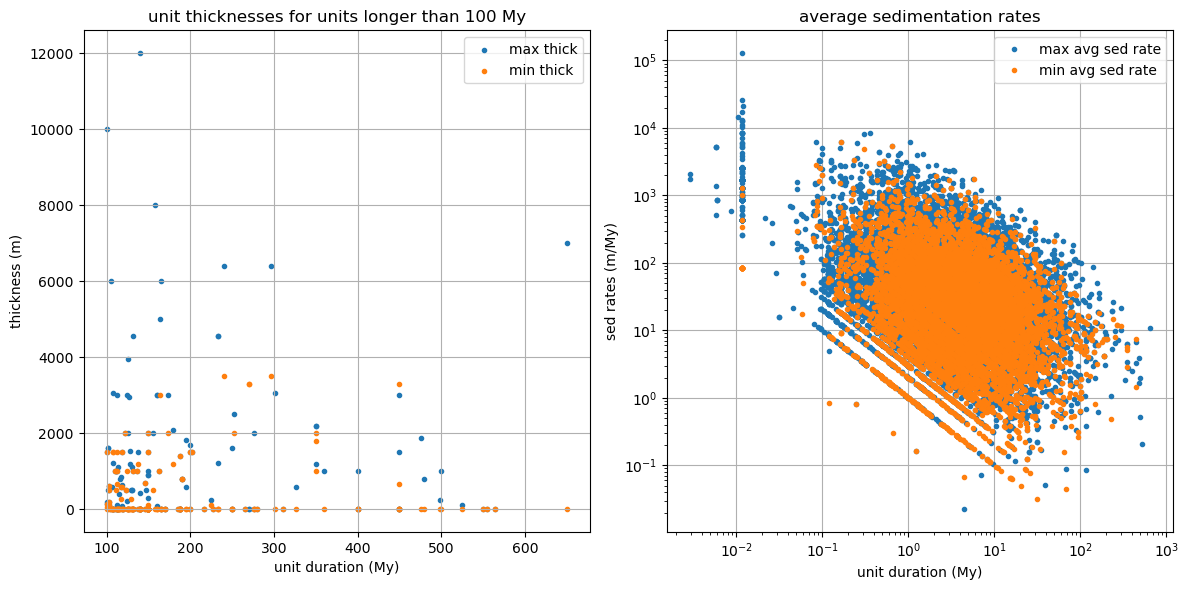

In [4]:
fig, ax = plt.subplots(1, 2, figsize=(12,6))

# plot thicknesses for long units
ax[0].scatter(t_ranges[long_units], units_seds[long_units]['max_thick'], marker='.', label='max thick')
ax[0].scatter(t_ranges[long_units], units_seds[long_units]['min_thick'], marker='.', label='min thick')
ax[0].set_xlabel('unit duration (My)')
ax[0].set_ylabel('thickness (m)')
ax[0].set_title('unit thicknesses for units longer than 100 My')
ax[0].legend()
ax[0].grid()

# plot average sedimentation rates vs unit duration
ax[1].loglog(t_ranges[idx_max], sedrate_max[idx_max], '.', label='max avg sed rate')
ax[1].loglog(t_ranges[idx_min], sedrate_min[idx_min], '.', label='min avg sed rate')
ax[1].set_xlabel('unit duration (My)')
ax[1].set_ylabel('sed rates (m/My)')
ax[1].set_title('average sedimentation rates')
ax[1].legend()
ax[1].grid()
plt.tight_layout()
plt.show()

From the above figure we already see a broad power law in sedimentation rate versus averaging timescale as theorized by Sadler, but with substantial spread. Subsequent work will focus on parsing out environmental signals to determine the timescales of saturation for various environments, if possible, from the Macrostrat dataset.

## units straddling time bounds

Given that units can and will straddle the boundary for a user-selected time interval, I propose the following scheme for accounting for units extending beyond these boundaries. Firstly, all sedimentation within units will be assumed to occur at a constant rate. Thus, the fraction of its total duration that a unit either succeeds the upper boundary or precedes the lower boundary (or both) is also the fraction of its accumulated thickness that is assumed not to have deposited within the chosen time interval. 

The following equations implement this model, where a weighting factor is computed that reflects the portion of the unit's thickness that is assumed to occur within the user-selected time bounds.

\begin{align} 
w &= \max\left(0, \frac{x}{d}\right) \\
x &= d - a - b \\
a &= \max\left(0, t^u_i-t^b_i \right) \\
b &= \max\left(0, t_f^b-t^u_f \right)
\end{align}

where the variables $t^u_i$, $t^b_i$ refer to the lower time bounds on the unit and time bin of interest, respectively, and $t_f^b$, $t^u_f$ refer to the upper time bounds on the time bin and unit, respectively. The following code block implements this correction.

In [5]:
# compute overlap weights for each unit and the given time bin
def bin_overlap_correction(units, t1, t2):
    d = units['b_age'].values - units['t_age'].values
    a = np.vstack((np.zeros((len(units))), 
                   units['b_age'].values - t1)).T
    a = np.max(a, axis=1)
    b = np.vstack((np.zeros((len(units))), 
                   t2 - units['t_age'].values)).T
    b = np.max(b, axis=1)
    w = (d - a - b)/d
    w[w < 0] = 0
    return w

## coeval units within columns

The next consideration is that units sometimes overlap temporally within columns. The vertical spatial height corresponding to the temporal overlap will be in general different for each of the units, given that they have different average sedimentation rates. When computing a maximum thickness estimate then, it would be desirable to remove the overlap corresponding to the more slowly accumulating units, leaving only the height corresponding to the fastest accumulating unit. When computing minimum thickness estimates, it would be desirable instead to take the thickness corresponding to the slowest accumulating unit over the duration of unit overlap.

Given that multiple units can overlap with each other, it is necessary to isolate each unique temporal interval of unit overlap, i.e. identifying the intervals where various units overlap with each other. For each of these intervals where $n$ units overlap, the unit thicknesses corresponding to the units with the $n-1$ minimum/maximum sedimentation rates are removed for the maximum/minimum sediment accumulation estimates, respectively. 

The following fairly lengthy code block implements this correction, and the algorithm outline is presented in [this document]('notes/Macrostrat_doublecount_correction.pdf').

In [6]:
# idx_groups: dictionary with col_ids and indices of units corresponding to each column
# units: dataframe indexed by idx_groups into columns
#
# generate thickness corrections to subtract from the thicknesses naively computed in seds_by_column_and_age
# correction are then positive
def unit_overlap_correction(idx_groups, units_in):
    cols = idx_groups.keys()
    # create dataframe of corrections (default zero correction)
    corr = pd.DataFrame(index=cols, columns=['max_corr', 'min_corr'])
    corr[:] = 0
    # loop over columns (might be faster with smart groupby() call)
    for col in cols:
        # units in column
        col_units = units_in.iloc[idx_groups.get(col)][['t_age', 'b_age', 'max_thick', 'min_thick']]
        # loop over units 
        n_units = len(col_units)
        ovlap_coords = []
        ovlap_units = []
        # find overlapping units
        for ii in range(n_units):
            for jj in range(ii+1, n_units):
                ti_t, ti_b = col_units.iloc[ii]['t_age'], col_units.iloc[ii]['b_age']
                tj_t, tj_b = col_units.iloc[jj]['t_age'], col_units.iloc[jj]['b_age']
                if (ti_b >= tj_t) & (tj_b >= ti_t):
                    ovlap_coords.append([np.max([ti_t, tj_t]), np.min([ti_b, tj_b])])
                    ovlap_units.append([ii,jj])
        # check if any units overlap, if not, return zero
        if len(ovlap_coords) == 0:
            continue
        
        # get average (max) sedimentation rate for each unit
        avg_sed_rates_max = col_units['max_thick']/(col_units['b_age']-col_units['t_age'])
        avg_sed_rates_min = col_units['min_thick']/(col_units['b_age']-col_units['t_age'])
        
        # having found overlapping units, (at II 1), pg. 4 ), find unique coordinates of overlapping segments
        unique_coords = np.unique(np.asarray(ovlap_coords))
        # create list with overlap vertices as indices
        ovlaps_verts_units = np.empty(len(unique_coords), dtype=object)
        for ii in range(len(unique_coords)):
            ovlaps_verts_units[ii] = [np.nan] * 1
        for coords, units in zip(ovlap_coords, ovlap_units):
            idx_coords = (unique_coords >= coords[0]) & (unique_coords <= coords[1])
            cur_ovlaps = ovlaps_verts_units[idx_coords]
            for ii in range(len(cur_ovlaps)):
                cur_ovlaps[ii] = cur_ovlaps[ii] + units
            ovlaps_verts_units[idx_coords] = cur_ovlaps
        for ii in range(len(ovlaps_verts_units)):
            # get unique unit indices
            ovlaps_verts_units[ii] = np.unique(np.asarray(ovlaps_verts_units[ii]))
            # get rid of nans
            not_na_idx = np.logical_not(np.isnan(ovlaps_verts_units[ii]))
            ovlaps_verts_units[ii] = ovlaps_verts_units[ii][not_na_idx]
            
        # now with array with overlapping vertices denoted by overlapping unit indices at each vertex, create
        # vector with entries denoting segments, not endpoints (pg.3 figure at bottom)
        n_ovlap_segs = len(unique_coords)-1
        ovlap_segs_units = np.empty(n_ovlap_segs, dtype=object)
        ovlap_segs_wids = np.zeros(n_ovlap_segs)
        for ii in range(n_ovlap_segs):
            ovlap_segs_units[ii] = list(set(ovlaps_verts_units[ii+1]) & set(ovlaps_verts_units[ii]))
            ovlap_segs_wids[ii] = unique_coords[ii+1] - unique_coords[ii]
        
        # subtract thinnest units of the overlapping ones (i.e. n-1 slowest avg sed rates times overlap width)
        # loop over vertices
        for ii in range(n_ovlap_segs):
            # get units in current overlapping segment
            cur_units = ovlap_segs_units[ii]
            # for each unit, get thicknesses (sed rates x durations)
            ovlap_thicks_max = np.sort(avg_sed_rates_max.iloc[cur_units].values * ovlap_segs_wids[ii])
            ovlap_thicks_min = np.sort(avg_sed_rates_min.iloc[cur_units].values * ovlap_segs_wids[ii])
            # take sum of smallest/largest thicknesses as maximum/minimum corrections
            corr.loc[col, 'max_corr'] = corr.loc[col, 'max_corr'] + np.sum(ovlap_thicks_max[0:-1])
            corr.loc[col, 'min_corr'] = corr.loc[col, 'min_corr'] + np.sum(ovlap_thicks_min[1:])
            
    return corr

The following function *seds_by_column_and_age_range()* then implements the column-wise sedimentary thickness computation within user-provided time bounds.

In [7]:
# units: dataframe of units in which to estimate thicknesses
# t[1] > t[0]
# method='thickness' (default), 'presence' : whether to estimate columnwise thicknesses or just presence/absence a la Peters/Husson. 
# returns:
#  tmp_df: dataframe indexed by col_id with column geometry. if method='presence', then the singular data column is boolean indicating presence of sediments within the requested time interval. if method='thickness', then two data columns are returned containing the maximum and minimum estimated accumulations of sediment within the requested time interval
def seds_by_column_and_age_range(units, columns, t1, t2, method='thickness'):
    assert t1 > t2, 't1 must be larger than t2'
    assert method in ['thickness', 'presence'], 'invalid value for method' 
    # copy data so we don't mess with originals
    units = units.copy()
    columns_tmp = columns.copy()
    columns_tmp.index = columns_tmp['col_id']
    
    # correct for units that span beyond t1 or t2
    w = bin_overlap_correction(units, t1, t2)
    # indices of units within time bounds
    idx_units_in_bounds = w != 0
    # if just looking for presence, then this is enough
    if method=='presence':
        tmp_df = columns_tmp[['geometry']].copy()
        units['presence'] = idx_units_in_bounds.astype(int)
        tmp_df['presence'] = units.groupby(['col_id']).sum()['presence']
        tmp_df.loc[tmp_df['presence'] > 0, 'presence'] = 1
        return tmp_df
    elif method=='thickness':
        # get just these units
        w = w[idx_units_in_bounds]
        units = units[idx_units_in_bounds]
        # apply weights
        max_thicks = w * units['max_thick'] 
        min_thicks = w * units['min_thick']
        units['max_thick'] = max_thicks
        units['min_thick'] = min_thicks
        # sum all seds in each columns
        grouped = units.groupby(['col_id'])
        thicknesses_cols = grouped[['min_thick', 'max_thick']].sum()
        # reset time bounds on units that straddle time bin
        units.loc[units['t_age'] < t2, 't_age'] = t2
        units.loc[units['b_age'] > t1, 'b_age'] = t1
        # get and apply thickness correction
        corr = unit_overlap_correction(grouped.indices, units)
        thicknesses_cols['max_thick'] = thicknesses_cols['max_thick'] - corr['max_corr']
        thicknesses_cols['min_thick'] = thicknesses_cols['min_thick'] - corr['min_corr']
        # combine thicknesses with column geometry
        tmp_df = columns_tmp[['geometry']].merge(thicknesses_cols, left_index=True, right_index=True, how='outer')
        # set nans to zeros
        nan_idx = np.isnan(pd.to_numeric(tmp_df['max_thick']))
        tmp_df.loc[nan_idx, 'max_thick'] = 0
        nan_idx = np.isnan(pd.to_numeric(tmp_df['min_thick']))
        tmp_df.loc[nan_idx, 'min_thick'] = 0
        # make numeric
        tmp_df['max_thick'] = pd.to_numeric(tmp_df['max_thick'])
        tmp_df['min_thick'] = pd.to_numeric(tmp_df['min_thick'])
        return tmp_df

## visualization

The functions below generate a widget for an interactive method of plotting accumulated thicknesses within time bounds specified by the user.

In [11]:
def plot_thicknesses(t):
    t1 = t[1]
    t2 = t[0]
    thicks = seds_by_column_and_age_range(units_seds, columns, t1, t2)
    
    fig, ax = plt.subplots(1, 2, figsize=(18, 8))
    
    vmax = thicks['max_thick'].max()
    
    # plot max thickness estimates
    thicks.plot(ax=ax[0], 
                column='max_thick',
                vmin = 0,
                vmax = vmax,
                legend=True,
                legend_kwds={'label': 'maximum thickness (m)'})
    ax[0].set_title('max thickness')
    
    # plot min thickness estimates
    thicks.plot(ax=ax[1], 
                column='min_thick',
                vmin = 0,
                vmax = vmax,
                legend=True, 
                legend_kwds={'label': 'minimum thickness (m)'})
    ax[1].set_title('min thickness')


In [12]:
range_widget = widgets.IntRangeSlider(value=[100, 300],
                                      min=0,
                                      max=1000,
                                      step=5,
                                      description='Age (Ma):',
                                      layout=widgets.Layout(width='90%'))

w = widgets.interact_manual(plot_thicknesses, t=range_widget)

display(w)

interactive(children=(IntRangeSlider(value=(100, 300), description='Age (Ma):', layout=Layout(width='90%'), ma…

<function __main__.plot_thicknesses(t)>